Extended Hubbard model on a 6-site ladder:
$$
H=-t\sum_{\{i,j\},\sigma} (c_{i,\sigma}^\dagger c_{j,\sigma}+c_{j,\sigma}^\dagger c_{i,\sigma})+U\sum_{i} n_{i\uparrow}n_{i\downarrow}
-V\sum_{\{\{i,j\}\}}(n_{i\uparrow}+n_{i\downarrow})(n_{j\uparrow}+n_{j\downarrow})-\mu \sum_{i,\sigma}n_{i,\sigma}
$$
其中粒子数算符$n_{i,\sigma}$定义为：
$$
n_{i,\sigma} = c_{i,\sigma}^\dagger c_{i,\sigma}
$$
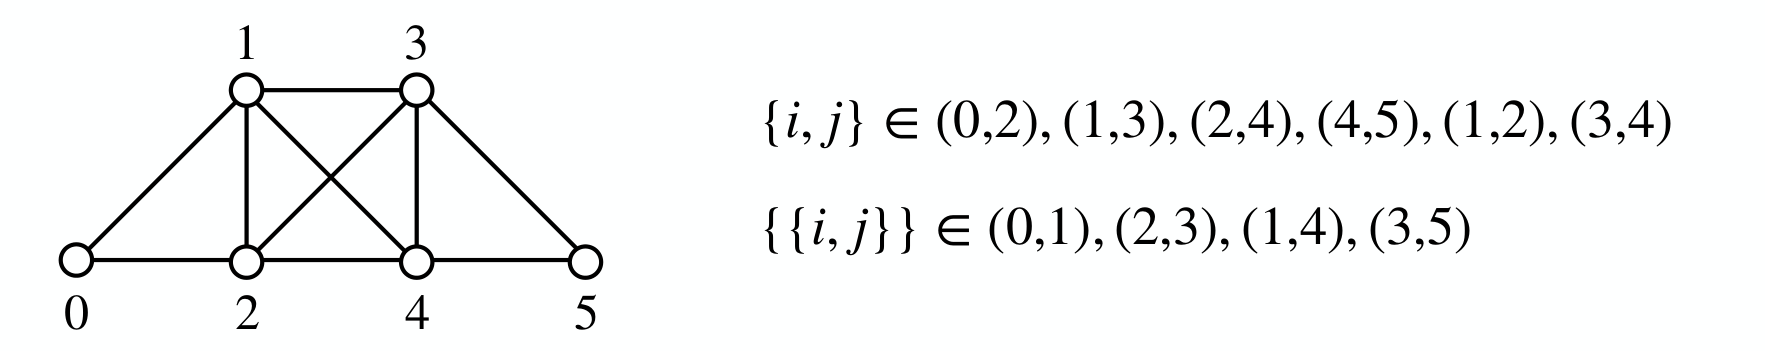

In [5]:
import numpy as np
import copy
import math
import scipy
from scipy import sparse



print("="*9+"Task 1:output"+"="*9)



# set up the parameters
t = 1.0
U = 8.0
V = 0.4
mu = 4.0



#flip nth bit
def FlipBit(i, n):
    return i^(1<<n)
#read nth bit(from right to left)
def ReadBit(i, n):
    return (i&(1<<n))>>n
#count how many 1 bits
def PopCntBit(i):
    return bin(i).count("1")
#list of integers to list of bit patterns
def int_to_bin (list_of_int):
    list_of_bin = [bin(k) for k in list_of_int]
    return list_of_bin


    
#define the hopping list
Hoplist_t = [[0,2],[1,3],[2,4],[4,5],[1,2],[3,4]]
Hoplist_V = [[0,1],[2,3],[1,4],[3,5]]




#create list of integer numbers with certain number of "1" in their binary representations
int_val_with_particle_num = [[] for i in range(7)]
for n in range(2**6):
    for k in range(7):
        if PopCntBit(n) == k:
            int_val_with_particle_num[k].append(n)
            

            
#we first consider the 2_up 4_down sector of this system
n_up = 2
n_down = 4
Ht,HU,HV,Hmu,HRt,HLt,HDU,HDV,HDmu = [],[],[],[],[],[],[],[],[]
up_arrow_bit_pattern = int_val_with_particle_num[n_up].copy()
down_arrow_bit_pattern = int_val_with_particle_num[n_down].copy()
up_arrow_dim = len(up_arrow_bit_pattern)
down_arrow_dim = len(down_arrow_bit_pattern)

Nl = up_arrow_dim * down_arrow_dim

for i0 in up_arrow_bit_pattern:
    for j0 in down_arrow_bit_pattern:
        
        #-t (off-diagonal) terms
        for iht in range(len(Hoplist_t)):
            Pos0 = Hoplist_t[iht][0]
            Pos1 = Hoplist_t[iht][1]
            if ReadBit(i0,Pos0) == 0 and ReadBit(i0,Pos1)==1:
                i1 = FlipBit(i0,Pos0)
                i1 = FlipBit(i1,Pos1)
                phase_factor = (-1)**(PopCntBit(PickBit(i0,Pos0+1,5-Pos0))+PopCntBit(PickBit(i0,Pos1+1,5-Pos1))-1)
                HLt.append(up_arrow_bit_pattern.index(i1)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                HRt.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                Ht.append(-t*phase_factor)
            if ReadBit(i0,Pos0) == 1 and ReadBit(i0,Pos1)==0:
                i1 = FlipBit(i0,Pos0)
                i1 = FlipBit(i1,Pos1)
                phase_factor =(-1)**(PopCntBit(PickBit(i0,Pos1+1,5-Pos1)) +PopCntBit(PickBit(i0,Pos0+1,5-Pos0)))
                HLt.append(up_arrow_bit_pattern.index(i1)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                HRt.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                Ht.append(-t*phase_factor)
            if ReadBit(j0,Pos0) == 0 and ReadBit(j0,Pos1)==1:
                j1 = FlipBit(j0,Pos0)
                j1 = FlipBit(j1,Pos1)
                phase_factor = (-1)**(PopCntBit(PickBit(j0,Pos0+1,5-Pos0))+PopCntBit(PickBit(j0,Pos1+1,5-Pos1))-1+2*PopCntBit(i0))
                HLt.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j1))
                HRt.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                Ht.append(-t*phase_factor)
            if ReadBit(j0,Pos0) == 1 and ReadBit(j0,Pos1)==0:
                j1 = FlipBit(j0,Pos0)
                j1 = FlipBit(j1,Pos1)
                phase_factor = (-1)**(PopCntBit(PickBit(j0,Pos1+1,5-Pos1)) +PopCntBit(PickBit(j0,Pos0+1,5-Pos0))+2*PopCntBit(i0))
                HLt.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j1))
                HRt.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                Ht.append(-t*phase_factor)   

        #U terms
        for iU in range(6):
            if ReadBit(i0,iU) == ReadBit(j0,iU) == 1:
                HDU.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                HU.append(U)
                
        #-V terms
        for ihV in range(len(Hoplist_V)):
            Pos0V = Hoplist_V[ihV][0]
            Pos1V = Hoplist_V[ihV][1]
            if ReadBit(i0,Pos0V) + ReadBit(i0,Pos1V) + ReadBit(j0,Pos0V) + ReadBit(j0,Pos1V) == 4:
                HDV.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                HV.append(-4*V)
            if ReadBit(i0,Pos0V) + ReadBit(i0,Pos1V) + ReadBit(j0,Pos0V) + ReadBit(j0,Pos1V) == 3:
                HDV.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                HV.append(-2*V)
            if ReadBit(i0,Pos0V)+ReadBit(i0,Pos1V)+ReadBit(j0,Pos0V)+ReadBit(j0,Pos1V) == 2 and ReadBit(i0,Pos0V)!= ReadBit(j0,Pos0V) :
                HDV.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                HV.append(-1*V)
        
        #-mu terms
        for imu in range(6):
            if ReadBit(i0,imu)+ReadBit(j0,imu) == 1:
                HDmu.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                Hmu.append(-1*mu)
            if ReadBit(i0,imu)+ReadBit(j0,imu) == 2:
                HDmu.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                Hmu.append(-2*mu)
                
#diagonal matrix                
Ham_off_d = sparse.coo_matrix((Ht,(HLt,HRt)),shape=(Nl,Nl)).tocsc()

#off-diagonal matrices
Ham_d_U = sparse.coo_matrix((HU,(HDU,HDU)),shape=(Nl,Nl)).tocsc()
Ham_d_V = sparse.coo_matrix((HV,(HDV,HDV)),shape=(Nl,Nl)).tocsc()
Ham_d_mu = sparse.coo_matrix((Hmu,(HDmu,HDmu)),shape=(Nl,Nl)).tocsc()

#subspace Hamiltonian matrix
Hamr = Ham_off_d + Ham_d_U + Ham_d_V + Ham_d_mu

H = Hamr.toarray()

#Diagonalize the Hamiltonian
evals, evecs = np.linalg.eig(H)
# Find the 6 lowest-lying eigenvalues
lowest_evals = np.sort(evals)[:6]

print("(1)_U(1)_sector_up2_down4:{}".format(lowest_evals))



#We next repeat our calculation for all the U(1) sector and find the lowest 20 eigenvalues of the whole system
whole_system_evals = []
whole_system_evecs = []
sectors = []
for n_up in range(7):
    for n_down in range(7):
        Ht,HU,HV,Hmu,HRt,HLt,HDU,HDV,HDmu = [],[],[],[],[],[],[],[],[]
        up_arrow_bit_pattern = int_val_with_particle_num[n_up].copy()
        down_arrow_bit_pattern = int_val_with_particle_num[n_down].copy()
        up_arrow_dim = len(up_arrow_bit_pattern)
        down_arrow_dim = len(down_arrow_bit_pattern)
        this_sector = [n_up,n_down]

        Nl = up_arrow_dim * down_arrow_dim

        for i0 in up_arrow_bit_pattern:
            for j0 in down_arrow_bit_pattern:
                
                #-t (off-diagonal) terms
                for iht in range(len(Hoplist_t)):
                    Pos0 = Hoplist_t[iht][0]
                    Pos1 = Hoplist_t[iht][1]
                    if ReadBit(i0,Pos0) == 0 and ReadBit(i0,Pos1)==1:
                        i1 = FlipBit(i0,Pos0)
                        i1 = FlipBit(i1,Pos1)
                        phase_factor = (-1)**(PopCntBit(PickBit(i0,Pos0+1,5-Pos0))+PopCntBit(PickBit(i0,Pos1+1,5-Pos1))-1)
                        HLt.append(up_arrow_bit_pattern.index(i1)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                        HRt.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                        Ht.append(-t*phase_factor)
                    if ReadBit(i0,Pos0) == 1 and ReadBit(i0,Pos1)==0:
                        i1 = FlipBit(i0,Pos0)
                        i1 = FlipBit(i1,Pos1)
                        phase_factor =(-1)**(PopCntBit(PickBit(i0,Pos1+1,5-Pos1)) +PopCntBit(PickBit(i0,Pos0+1,5-Pos0)))
                        HLt.append(up_arrow_bit_pattern.index(i1)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                        HRt.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                        Ht.append(-t*phase_factor)
                    if ReadBit(j0,Pos0) == 0 and ReadBit(j0,Pos1)==1:
                        j1 = FlipBit(j0,Pos0)
                        j1 = FlipBit(j1,Pos1)
                        phase_factor = (-1)**(PopCntBit(PickBit(j0,Pos0+1,5-Pos0))+PopCntBit(PickBit(j0,Pos1+1,5-Pos1))-1+2*PopCntBit(i0))
                        HLt.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j1))
                        HRt.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                        Ht.append(-t*phase_factor)
                    if ReadBit(j0,Pos0) == 1 and ReadBit(j0,Pos1)==0:
                        j1 = FlipBit(j0,Pos0)
                        j1 = FlipBit(j1,Pos1)
                        phase_factor = (-1)**(PopCntBit(PickBit(j0,Pos1+1,5-Pos1)) +PopCntBit(PickBit(j0,Pos0+1,5-Pos0))+2*PopCntBit(i0))
                        HLt.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j1))
                        HRt.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                        Ht.append(-t*phase_factor)   

                #U terms
                for iU in range(6):
                    if ReadBit(i0,iU) == ReadBit(j0,iU) == 1:
                        HDU.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                        HU.append(U)
                        
                #-V terms
                for ihV in range(len(Hoplist_V)):
                    Pos0V = Hoplist_V[ihV][0]
                    Pos1V = Hoplist_V[ihV][1]
                    if ReadBit(i0,Pos0V) + ReadBit(i0,Pos1V) + ReadBit(j0,Pos0V) + ReadBit(j0,Pos1V) == 4:
                        HDV.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                        HV.append(-4*V)
                    if ReadBit(i0,Pos0V) + ReadBit(i0,Pos1V) + ReadBit(j0,Pos0V) + ReadBit(j0,Pos1V) == 3:
                        HDV.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                        HV.append(-2*V)
                    if ReadBit(i0,Pos0V)+ReadBit(i0,Pos1V)+ReadBit(j0,Pos0V)+ReadBit(j0,Pos1V) == 2 and ReadBit(i0,Pos0V)!= ReadBit(j0,Pos0V) :
                        HDV.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                        HV.append(-1*V)
                
                #-mu terms
                for imu in range(6):
                    if ReadBit(i0,imu)+ReadBit(j0,imu) == 1:
                        HDmu.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                        Hmu.append(-1*mu)
                    if ReadBit(i0,imu)+ReadBit(j0,imu) == 2:
                        HDmu.append(up_arrow_bit_pattern.index(i0)*down_arrow_dim + down_arrow_bit_pattern.index(j0))
                        Hmu.append(-2*mu)
                        
        #diagonal matrix                
        Ham_off_d = sparse.coo_matrix((Ht,(HLt,HRt)),shape=(Nl,Nl)).tocsc()

        #off-diagonal matrices
        Ham_d_U = sparse.coo_matrix((HU,(HDU,HDU)),shape=(Nl,Nl)).tocsc()
        Ham_d_V = sparse.coo_matrix((HV,(HDV,HDV)),shape=(Nl,Nl)).tocsc()
        Ham_d_mu = sparse.coo_matrix((Hmu,(HDmu,HDmu)),shape=(Nl,Nl)).tocsc()

        #subspace Hamiltonian matrix
        Hamr = Ham_off_d + Ham_d_U + Ham_d_V + Ham_d_mu

        H = Hamr.toarray()

        #Diagonalize the Hamiltonian
        evals, evecs = np.linalg.eig(H)

        #add the new evals
        whole_system_evals = np.concatenate((whole_system_evals,evals),axis=0)
        
        #add the new evecs
        whole_system_evecs += [evecs[:,k] for k in range(evecs.shape[0])]
        
        #record the sector
        sectors += [this_sector]*len(evals)
        
#find the lowest 20 evals of the whole system
lowest_20 = np.sort(whole_system_evals)[:20]
print("(2)_lowest_20_eigenvalues:{}".format(np.round(lowest_20,decimals=8)))



#we next calculate the density of up spin w.r.t. the true ground state of the system:
indices = np.argsort(whole_system_evals)
true_ground_state = whole_system_evecs[indices[0]]
sector = sectors[indices[0]]

#calculate the expectation values <n_i_sigma>
n_up_gs = sector[0]
n_down_gs = sector[1]
up_arrow_bit_pattern = int_val_with_particle_num[n_up_gs].copy()
down_arrow_bit_pattern = int_val_with_particle_num[n_down_gs].copy()
up_arrow_dim = len(up_arrow_bit_pattern)
down_arrow_dim = len(down_arrow_bit_pattern)
Nl = up_arrow_dim * down_arrow_dim
dense_list_up = []
dense_list_down = []
for site_up in range(6):
    occupy_list_up = []
    for i0 in up_arrow_bit_pattern:
        if ReadBit(i0,site_up) == 1:
            occupy_list_up += [down_arrow_dim*up_arrow_bit_pattern.index(i0) + down_arrow_bit_pattern.index(j) for j in down_arrow_bit_pattern]
    sum_entries = [true_ground_state[ent] for ent in occupy_list_up]
    sum_entries = [k**2 for k in sum_entries]
    dense_list_up.append(np.sum(sum_entries))
for site_down in range(6):
    occupy_list_down = []
    for j0 in down_arrow_bit_pattern:
        if ReadBit(j0,site_down) == 1:
            occupy_list_down += [down_arrow_dim*up_arrow_bit_pattern.index(i) + down_arrow_bit_pattern.index(j0) for i in up_arrow_bit_pattern]
    sum_entries = [true_ground_state[ent] for ent in occupy_list_down]
    sum_entries = [k**2 for k in sum_entries]
    dense_list_down.append(np.sum(sum_entries))
print("(3)_Density_Up_Spin:{}".format(np.round(dense_list_up,decimals=8)))
print("(3)_Density_Down_Spin:{}".format(np.round(dense_list_down,decimals=8)))

=========Task 1:output=========
(1)_U(1)_sector_up2_down4:[-27.30624878 -27.00069745 -26.92490668 -26.77252547 -26.66863714
 -26.54837612]
(2)_lowest_20_eigenvalues:[-27.52865033 -27.30624878 -27.30624878 -27.30624878 -27.00069745
 -27.00069745 -27.00069745 -26.92490668 -26.92490668 -26.92490668
 -26.81123368 -26.77252547 -26.77252547 -26.77252547 -26.77252547
 -26.77252547 -26.67702648 -26.66863714 -26.66863714 -26.66863714]
(3)_Density_Up_Spin:[0.49979075 0.50139373 0.49881552 0.50139373 0.49881552 0.49979075]
(3)_Density_Down_Spin:[0.49979075 0.50139373 0.49881552 0.50139373 0.49881552 0.49979075]
